In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [7]:
business_account = pd.read_excel("../shared_data_read_only/Business Account.xlsx")
consumer_price_index = pd.read_excel("../shared_data_read_only/consumer_price_index.xlsx")
contacts = pd.read_excel("../shared_data_read_only/Contacts.xlsx")
data_dictionary = pd.read_excel("../shared_data_read_only/Data dictionary.xlsx")
invoice_opportunities = pd.read_excel("../shared_data_read_only/Invoice and Opportunities.xlsx")
items_opportunities = pd.read_excel("../shared_data_read_only/Items and Opportunities.xlsx")
non_stock_items = pd.read_excel("../shared_data_read_only/Non-Stock Items.xlsx")
opportunities = pd.read_excel("../shared_data_read_only/Opportunities.xlsx")

In [8]:
# Clean Countries
business_account["Country Name"].unique()
uncorrect=["Belgique",'Royaume-Uni','États-Unis',"Suisse","Allemagne","Espagne"]
correct=['Belgium','United Kingdom of Great Britain and Northern Ireland','United States of America','Switzerland',"Germany","Spain"]
for k in range(len(uncorrect)):
    business_account[business_account['Country Name']==uncorrect[k]]=correct[k]

business_account["Country Name"].unique()

business_temp=business_account.copy(deep=True)

# Clean for Paris
for k in range(len(business_temp)):
    
    if "paris" in str(business_temp.iloc[k,:]['City']).lower():
        business_temp.loc[k,"City"]="paris"

print(len(business_temp['City'].unique()))
len(business_account['City'].unique())

# From Postal Code obtain department, for France
business_temp["Dep"]=business_temp["Postal Code"].apply(lambda x: str(x)[:2])

# For France : department, for other countries : Country Name
business_temp.loc[business_temp['Country Name']!="France","Dep"]=business_temp['Country Name']
business_temp.loc[business_temp['Postal Code'].isna(),"Dep"]=business_temp['Country Name']

816


In [9]:
# We will train our models on won opportunities, which have received all payments

df_won=opportunities[opportunities['Status']=="Won"]
print(len(df_won))
print(len(df_won[~df_won['Amount received'].isna()]))

4108
2572


In [15]:
# Remove na which have not received any payment : discrepencies in data ?
df_won_f=df_won[~df_won['Amount received'].isna()]

# Filter on relevant columns
df_won_filtered=df_won_f[['Opportunity ID','Business Account','Status','Stage','Amount received','Estimated amount','Created On','Actual Close Date']]


# Merge opportunities on transformed business acount dataframe in order to add information on the its country, sector, partner type
df_won__tot=pd.merge(df_won_filtered,business_temp[['Business Account','Country Name','Activity sector','Partner type']],on="Business Account")

# We compute the target output for known data : number of payments and the average amount received per payment
# We would like to study time average weighted by amount received (not studied)
for row in df_won__tot.index:
    try:
        id = df_won__tot.loc[row, "Opportunity ID"]
        invoice_opportunities_filter = invoice_opportunities[invoice_opportunities["Opportunity ID"] == id]
        y_mean = invoice_opportunities_filter["Amount"].mean()
        nb_p = len(invoice_opportunities_filter["Amount"])
        df_won__tot.loc[row,"y_mean"] = y_mean
        df_won__tot.loc[row,"nb_p"] = nb_p
        
        y = invoice_opportunities_filter
    except Exception as e:
        print(e)
        pass

df_won__tot["Delta t"]=(df_won__tot["Actual Close Date"]-df_won__tot["Created On"])

In [16]:
# Creation of the training dataset by labelling our features
df_train=df_won__tot.loc[:,~df_won__tot.columns.isin(["Amount received","Status","Opportunity ID","Actual Close Date","Created On"])]
label_encoder = LabelEncoder()
df_train.loc[:,"Business Account"]=df_train.loc[:,"Business Account"].apply(lambda x:int(x[1:]))
df_train.loc[:,'Activity sector'] = pd.Series(label_encoder.fit_transform(df_train['Activity sector']))
df_train.loc[:,'Country Name'] = pd.Series(label_encoder.fit_transform(df_train['Country Name']))
df_train.loc[:,'Partner type'] = pd.Series(label_encoder.fit_transform(df_train['Partner type']))
df_train.loc[df_train['Stage']=="Won","Stage"]=5
df_train.loc[df_train['Stage']=="Oral agreement","Stage"]=4
df_train.loc[df_train['Stage']=="Advanced Prospect","Stage"]=3
df_train.loc[df_train['Stage']=="Dossier posed","Stage"]=2
df_train.loc[df_train['Stage']=="Initial Prospect","Stage"]=1
df_train['Delta t']=df_train['Delta t'].apply(lambda x:x.days)
df_train.dropna(inplace=True)

# target : average amount received
X, y = df_train.loc[:,~df_train.columns.isin(["y_mean","nb_p"])],  df_train.loc[:,["y_mean"]]

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Create a Random Forest classifier
rf_classifier = RandomForestRegressor(n_estimators=100, random_state=30)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Mean Absolute Error (MAE): 1125.67


<AxesSubplot:>

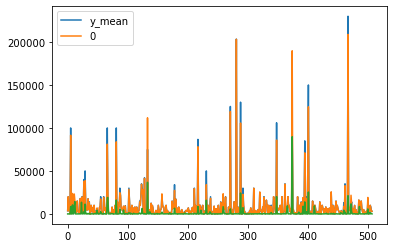

In [18]:
pd.concat([y_test.reset_index(drop=True),pd.DataFrame(y_pred)], axis=1).plot()


t=pd.concat([y_test.reset_index(drop=True),pd.DataFrame(y_pred)],axis=1)
(t.iloc[:,0]-t.iloc[:,1]).abs().plot()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Mean Absolute Error (MAE): 1783.28 for random_state = 12


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Mean Absolute Error (MAE): 2472.38 for random_state = 24


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Mean Absolute Error (MAE): 1125.67 for random_state = 30


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Mean Absolute Error (MAE): 1100.58 for random_state = 36


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Mean Absolute Error (MAE): 2288.60 for random_state = 50


<AxesSubplot:>

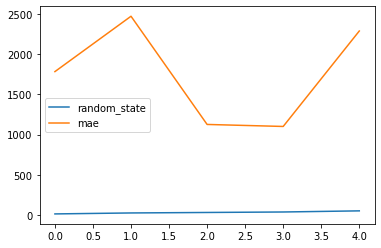

In [22]:
# fine-tuning of random_state parameter
value_mae=[]
for k in [12, 24, 30, 36, 50]:
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=k)

    # Create a Random Forest classifier
    rf_classifier = RandomForestRegressor(n_estimators=100, random_state=k)

    # Fit the classifier to the training data
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    value_mae.append(mae)
    print(f"Mean Absolute Error (MAE): {mae:.2f} for random_state = {k}")

pd.DataFrame({"random_state": [12, 24, 30, 36, 50], "mae": value_mae}).plot()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Mean Absolute Error (MAE): 1100.58


<AxesSubplot:title={'center':'(Amount Predicted-Real Amount Given)/Real Amount Given'}>

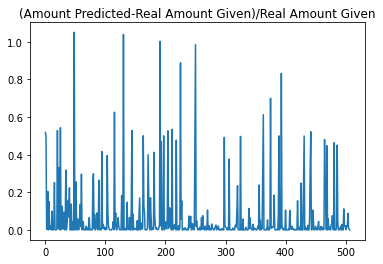

In [20]:
# We keep random_state = 36
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

# Create a Random Forest classifier
rf_classifier = RandomForestRegressor(n_estimators=100, random_state=36)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


# Plot the relative error 
t=pd.concat([y_test.reset_index(drop=True),pd.DataFrame(y_pred)],axis=1)
((t.iloc[:,0]-t.iloc[:,1])/t.iloc[:,1]).abs().plot(title="(Amount Predicted-Real Amount Given)/Real Amount Given")
